List of questions for investigation:

Try changing the architecture to add more editing output heads.

-Add a cut-point for the GPT2 editor, so that it doesn't have to go more than, say, 6 layers before we graft the head!

-Does this allow the model to perform much more successfully on KL benchmarks, reducing the loss greatly?
-Might it even allow for more accurate / faster discovery of the correct solutions / not getting trapped?

Can we already get results when we try this on the IOI task?

How much do we lose when we move from soft to hard labels?

Architectual Things to try:
-turn off token position 0
-penalize the advantages that token position 0 has as an editing location
-architecture: don’t merge together the attention mechanisms for all layers because this is giving us bad off-target effects. independently parametrize at all layers, or introduce some sort of a “layer embedding”
-ignore negative results and just scale up

In [ ]:
edit_layer = 0
edit_scale = 1/10 #this does not affect anything if edit_layer = 0
num_editing_heads = 64 #16 heads seems to work but takes 40 epochs. 32 heads worked immediately after just a few epochs. 64 also works immediately after a few epochs

# This file has a prototype editor hypernetwork
import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project="hypernetworks",
    config={"targetmodel": "gpt2", "editormodel": "gpt2"},
)
# Copy this below where needed!
# run.log_model(path="<path-to-model>", name="<name>")

# wandb.log({"acc": acc, "loss": loss})

# wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michaelbsklar (michaelsklar). Use `wandb login --relogin` to force relogin


In [2]:
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2Model
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import transformers
from tqdm import tqdm
import pandas as pd
import yaml
import contextlib
import os

In [3]:
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
# Set torch default device
torch.set_default_device("cuda")

In [5]:
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [6]:
def add_cross_attention_to_layer(block, config):
    block.crossattention = GPT2Attention(config, is_cross_attention=True)
    block.ln_cross_attn = nn.LayerNorm(
        normalized_shape=768, eps=config.layer_norm_epsilon
    )
    original_query_weights = block.attn.c_attn.weight[:, :768]
    original_keys_values = block.attn.c_attn.weight[:, 768:]
    original_query_bias = block.attn.c_attn.bias[:768]
    original_keys_values_bias = block.attn.c_attn.bias[768:]
    with torch.no_grad():
        # Initialize the new layer with these parameters
        block.crossattention.q_attn.weight = nn.Parameter(original_query_weights)
        block.crossattention.q_attn.bias = nn.Parameter(original_query_bias)
        block.crossattention.c_attn.weight = nn.Parameter(original_keys_values)
        block.crossattention.c_attn.bias = nn.Parameter(original_keys_values_bias)
    return

In [7]:
# for i in range(12):
#     add_cross_attention_to_layer(model,i)

In [8]:
# #Setting up to test the forward pass
# edit_instructions = "replace dog with cat" #Note to self: it's a good idea, for purposes of auto-editing, to look into how hard it is to get the editor to literally replace one set of tokens with another; since the encoding is literally the "correct" optimal solution in this case, so we can directly check if it's working on a task where the edit is equivalent to token replacement. Will tell us how many samples are necessary, can it possible work, etc.
# editor_ids = tokenizer.encode(edit_instructions, return_tensors="pt")


# target_ids = tokenizer.encode("the quick brown fox jumped over the lazy cat", return_tensors='pt')
# with torch.no_grad():  # No need to calculate gradients
#         targetmodel = GPT2Model.from_pretrained('gpt2', output_hidden_states=True)  # Set output_hidden_states to True
#         outputs = targetmodel(target_ids)
#         hidden_states = outputs.hidden_states  # Output has shape [num_layers, batch_size, sequence_length, hidden_size]

# encoded_hidden_states = torch.cat(hidden_states, dim=1)
# # The forward pass runs, with the usual output head
# # res = model(editor_ids, encoder_hidden_states=encoded_hidden_states, output_hidden_states=True)
# # res[0].shape

Now, we stick on the "Editor_Attention" module at the end!
This is a customized attention head that uses one BIG softmax.

In [9]:
class Editor_Attention(nn.Module):
    def __init__(self, config):
        super().__init__()

        #Controls whether the head will do a global softmax in all positions & layers
        #If True, the attn is global and will sum to 1
        #If False, the attn is a logistic fxn independently for every layer & token
        #I suspect we will also want to penalize the intervention norm
        self.global_softmax = config.global_softmax
        self.num_editing_heads = config.num_editing_heads #should default to 1, but we're going to test adding more
        if config.hidden_size % self.num_editing_heads != 0:
            print("Error: config hidden size is not divisible by num_editing_heads")
        self.head_dim = config.hidden_size // self.num_editing_heads
        self.embed_dim = config.hidden_size

        max_positions = config.max_position_embeddings
        self.register_buffer(
            "bias",
            torch.tril(
                torch.ones((max_positions, max_positions), dtype=torch.bool)
            ).view(1, 1, max_positions, max_positions),
            persistent=False,
        )
        self.register_buffer("masked_bias", torch.tensor(-1e4), persistent=False)

        # We compute Q and K as a single nn.linear; but will later break apart into subcomponents
        self.q_attn = nn.Linear(self.embed_dim, self.embed_dim)
        self.k_attn = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_attn = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)  # newly added!
        
    def _split_heads(self, x):
        """Split the last dimension into (num_heads, head_dim)."""
        new_shape = x.size()[:-1] + (self.num_editing_heads, self.head_dim)
        return x.view(*new_shape)
    
    def _new_reverse_attn(self, query, key, value, attention_mask=None, head_mask=None):
        # Assume that we are doing softmax attention

        # Project and split the query, key, value tensors
        split_query = self._split_heads(self.q_attn(query))
        split_key = self._split_heads(self.k_attn(key))
        split_value = self._split_heads(self.v_attn(value))
        
        if split_query.dim() != 4:
            print("Error: Expected query to be 4D tensor, but got something else!")
        if split_key.dim() != 3:
            print("Error: Expected key to be 3D tensor, but got something else!")
        if split_value.dim() != 3:
            print("Error: Expected value to be 3D tensor, but got something else!")

        # Query should be shaped as (batch_index, sequence_index, head_index, head_dim)
        # Key and value should be shaped as (batch_index, head_index, head_dim)
    
        KQ_weights = torch.matmul(split_query.permute(0,2,1,3),split_key.unsqueeze(-1)).squeeze(-1)

        # Then we take the softmax within the positional divisions
        softmaxed_weights = nn.functional.softmax(KQ_weights, dim=-1)
        
        # Adjusting value selection for head dimension
        attn_output = torch.matmul(softmaxed_weights.unsqueeze(-1), split_value.unsqueeze(-2))

        #combine heads: change 50, 8, 104, 96 to 50, 104, 768
        #first, permute
        attn_output = attn_output.permute(0,2,1,3)
        #combin heads x head_dims
        attn_output = attn_output.reshape(-1,attn_output.size(1),attn_output.size(2)*attn_output.size(3))
        # now project back
        projected_output = self.out_proj(attn_output)
    
        return projected_output, softmaxed_weights

    def _reverse_attn(self, query, key, value, attention_mask=None, head_mask=None):
        # The softmax is global over ALL attentions if num_editing_heads = 1
        # We also only use reverse attention from the final token of the edit sequence (last position in key)

        # Awkward error handling, because apparently, it seems like if the batch size is 1,
        # we wind up with a 3D tensor, not a 4D tensor??? Should trace this issue back!
        
        if self.global_softmax:
            if key.dim() == 4:
                K_reduced = key[
                    :, :, -1, :
                ]  # R# Check: that the second dimension of K is only a single element when we have batching
                # ^I believe this line is selecting only the last layer for editing output? check this!
                KQ_weights = torch.bmm(K_reduced, query.transpose(1, 2))
                #Then we take the softmax within the positional divisions
                softmaxed_weights = nn.functional.softmax(KQ_weights, dim=2)
                attn_output = torch.bmm(
                    softmaxed_weights.transpose(1, 2), value[:, :, -1, :]
                )

            if key.dim() == 3:
                QK_weights = torch.matmul(query, key.transpose(-1, -2))
                softmaxed_weights = nn.functional.softmax(QK_weights, dim=1)
                attn_output = torch.matmul(softmaxed_weights, value)

            return attn_output, softmaxed_weights

        if self.global_softmax == False:
            if key.dim() == 4:
                K_reduced = key[
                    :, :, -1, :
                ]  # R# Check: that the second dimension of K is only a single element when we have batching
                KQ_weights = torch.bmm(K_reduced, query.transpose(1, 2))
                logistic_weights = torch.atan(KQ_weights)
                attn_output = torch.bmm(
                    logistic_weights.transpose(1, 2), value[:, :, -1, :]
                )

            if key.dim() == 3:
                QK_weights = torch.matmul(query, key.transpose(-1, -2))
                logistic_weights = torch.atan(QK_weights)
                attn_output = torch.matmul(logistic_weights, value)

            return attn_output, logistic_weights


    def forward(
        self,
        editor_hidden_states,
        target_hidden_states,
        attention_mask=None,
        output_attentions=False,
    ):

        # Here, the query is the target hidden encoder, the key is the editor, and the value is the editor
        query = self.q_attn(target_hidden_states)
        if editor_hidden_states.dim() == 3:
            key = self.k_attn(
                # I don't quite understand why sometimes editor_hidden_states is 4 dimensional, sometimes 3
                #seems like it's sometimes 20, 1, 4, 768 and sometimes 20, 4, 768. what gives?
                editor_hidden_states[:, -1, :]
            )  # Pull only the final token position
            value = self.v_attn(
                # [:, 0, :1, :]
                editor_hidden_states[:, -1, :]
            )  # Pull only the final token position

        if editor_hidden_states.dim() == 4:
            key = self.k_attn(
                editor_hidden_states[:, 0, -1, :]
            )  # Pull only the final token position
            value = self.v_attn(
                # [:, 0, :1, :]
                editor_hidden_states[:, 0, -1, :]
            )  # Pull only the final token position

        attn_output, attn_weights = self._new_reverse_attn(query, key, value)

        if output_attentions:
            return attn_output, attn_weights
        else:
            return attn_output

In [10]:
import types
from typing import Optional, Tuple, Union


def new_forward(
    self,
    input_ids: Optional[torch.LongTensor] = None,
    past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
    attention_mask: Optional[torch.FloatTensor] = None,
    token_type_ids: Optional[torch.LongTensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    head_mask: Optional[torch.FloatTensor] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    encoder_hidden_states: Optional[torch.Tensor] = None,
    encoder_attention_mask: Optional[torch.FloatTensor] = None,
    # labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
) -> Union[Tuple]:
    r"""
    labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
        Labels for language modeling. Note that the labels **are shifted** inside the model, i.e. you can set
        `labels = input_ids` Indices are selected in `[-100, 0, ..., config.vocab_size]` All labels set to `-100`
        are ignored (masked), the loss is only computed for labels in `[0, ..., config.vocab_size]`
    """

    transformer_outputs = self.transformer(
        input_ids,
        past_key_values=past_key_values,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        position_ids=position_ids,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
        encoder_hidden_states=encoder_hidden_states,
        encoder_attention_mask=encoder_attention_mask,
        use_cache=use_cache,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
    )
    hidden_states = transformer_outputs[0]

    # Set device for model parallelism
    if self.model_parallel:
        torch.cuda.set_device(self.transformer.first_device)
        hidden_states = hidden_states.to(self.lm_head.weight.device)

    # lm_logits = self.lm_head(hidden_states)
    reverse_attention_output = self.lm_head(
        hidden_states, encoder_hidden_states, output_attentions=output_attentions
    )

    return reverse_attention_output

In [11]:
# outputs.hidden_states[0].shape

In [12]:
def replace_linear_final_layer_with_bespoke_reverse_attention(model):
    model.lm_head = Editor_Attention(config=model.config)
    model.forward = new_forward.__get__(model, GPT2LMHeadModel)
    return


# replace_linear_final_layer_with_bespoke_reverse_attention(model)

In [13]:
@contextlib.contextmanager
def add_fwd_hooks(module_hooks):
    """
    Context manager for temporarily adding forward hooks to a model.

    Parameters
    ----------
    module_hooks
        A list of pairs: (module, fnc) The function will be registered as a
            forward hook on the module
    """
    try:
        handles = []
        for mod, hk in module_hooks:
            handles.append(mod.register_forward_hook(hk))
        yield
    finally:
        for h in handles:
            h.remove()

In [14]:
def assign_layer_indices(model):
    """
    Assigns a custom attribute 'layer_index' to each transformer layer in the GPT-2 model.
    This function iterates over the transformer blocks and assigns an index to each.
    """
    model.transformer.wte.layer_index = 0
    for i, layer in enumerate(model.transformer.h):
        layer.layer_index = i + 1


# Usage:
# assign_layer_indices(target_model)

In [15]:
class EditorHypernetwork(nn.Module):
    # Separating the editor config file, from its base model's configurations
    def __init__(self, 
        editor_yaml_file_path="config/editor_omniscient.yaml", 
        global_softmax=False,
        num_editing_heads=32,
        use_layerwise_embeddings=True,
        edit_dampening_factor=.001#tuning parameter to help the edits not be initialized too large
        ):

        super().__init__()

        # Construct Editor Model
        # Load the configuration from the YAML file
        # with open(editor_yaml_file_path, 'r') as file:
        #     self.config = yaml.safe_load(file)
        self.editor_model = GPT2LMHeadModel.from_pretrained(
            "gpt2"
        ).cuda().eval()  # have recently added .cuda() so it uses the gpu

        # Add cross-attention to each layer
        self.editor_model.config.add_cross_attention = True
        self.editor_model.config.global_softmax = global_softmax
        self.editor_model.config.num_editing_heads = num_editing_heads
        
        for i in range(12):
            add_cross_attention_to_layer(
                self.editor_model.transformer.h[i], self.editor_model.config
            )
        # Replace the final linear layer with special reverse attention output
        self.editor_model.lm_head = Editor_Attention(config=self.editor_model.config)
        self.editor_model.forward = new_forward.__get__(
            self.editor_model, GPT2LMHeadModel
        )
        self.editor_model.cuda()

        # Construct Target Model
        self.target_model = transformers.AutoModelForCausalLM.from_pretrained(
            "gpt2"
        ).cuda().eval()
        for param in self.target_model.parameters():
            param.requires_grad = False
        assign_layer_indices(self.target_model)

        self.target_model.cuda()

        # Add module for layerwise embeddings
        if use_layerwise_embeddings:
            self.use_layerwise_embeddings = True
            self.layerwise_embeddings = torch.randn(13, 768, requires_grad=True).cuda()
        else:
            self.use_layerwise_embeddings = False
            self.layerwise_embeddings = 0

        self.edit_dampening_factor = edit_dampening_factor

        self.residual_cache = None
        self.opt = None
        self.lossfn = None
        self.lam = None
        self.penalty_loss= None
        self.training_loss = None

    # Gets the hidden states from the target model, if necessary
    def run_target_model_for_encoded_hidden_states(self, target_ids):
        with torch.no_grad():
            outputs = self.target_model(target_ids, output_hidden_states=True)
            hidden_states = outputs.hidden_states
            return hidden_states

    def forward(
        self,
        editor_input_ids,
        target_input_ids,
        target_hidden_states=None,
        output_target_hidden_states=False,
        output_edited_hidden_states=False,
        output_edit_vectors=False,
        output_editor_attention=False,
        stop_editing_index=None,
        batch_edit_vectors=None,
    ):

        # Run target model for encoded hidden states
        if target_hidden_states is None:
            target_hidden_states = torch.stack(
                self.run_target_model_for_encoded_hidden_states(
                    target_input_ids.to("cuda")
                ),
                dim=2,
            )
        # dimensions of target_hidden_states:
        # batch_size, token_sequence_length, num_layers = 13, resid_width = 768

        # If we are stopping editing at stop_editing_index, then we eliminate target_hidden_states beyond that index
        if stop_editing_index is not None:
            target_hidden_states = target_hidden_states[
                :, :stop_editing_index, :, :
            ].clone()

        # Normalize along the last dimension
        normalization_factors = target_hidden_states.norm(dim=-1, keepdim=True)
        target_hidden_states = target_hidden_states / normalization_factors

        # Error catching:
        if batch_edit_vectors is not None:
            if output_edit_vectors or output_editor_attention:
                return "Error: Inputting your own batch_edit_vectors means the model does not construct the outputs you are requesting"

        # Run editor model, get edit vectors
        if batch_edit_vectors is None:
            if self.use_layerwise_embeddings:
                # Now, add in the layerwise embeddings
                embedded_hidden_states = target_hidden_states + self.layerwise_embeddings[None, None, :, :]

                collapsed_target_hidden_states = embedded_hidden_states.reshape(
                    target_hidden_states.shape[0],
                    target_hidden_states.shape[1] * target_hidden_states.shape[2],
                    target_hidden_states.shape[3],
                )
            else:
                collapsed_target_hidden_states = target_hidden_states.reshape(
                    target_hidden_states.shape[0],
                    target_hidden_states.shape[1] * target_hidden_states.shape[2],
                    target_hidden_states.shape[3],
                )
            
            editor_output = self.editor_model(
                editor_input_ids.to("cuda"),
                encoder_hidden_states=collapsed_target_hidden_states,
                output_attentions=output_editor_attention,
            )
            # Multiply the outputs by normalization factors
            if output_editor_attention:
                temp_edit_vectors = editor_output[0]
                # Might want to reshape this too but whatever
                batch_editor_attention = editor_output[1]
            else:
                temp_edit_vectors = editor_output
            
            #Renormalize to the scale of the target hidden states
            #and reshape to proper dimensions
            batch_edit_vectors = self.edit_dampening_factor * normalization_factors * temp_edit_vectors.reshape(
                    temp_edit_vectors.shape[0], stop_editing_index, 13, 768
                )
            
        # If we are stopping editing at stop_editing_index,
        # this pads batch_edit_vectors with 0's to the right of the edited positions
        if stop_editing_index is not None:
            batch_edit_vectors = torch.cat(
                (
                    batch_edit_vectors,
                    torch.zeros(
                        batch_edit_vectors.shape[0],
                        target_input_ids.shape[1] - stop_editing_index,
                        13,
                        768,
                    ),
                ),
                dim=1,
            )

        # Run target model with edit vectors. This adds the edit vectors to the given hidden state at the specified batch index, position, and layer
        def edit_add(module, input, output):
            layer_index = module.layer_index
            output[0][:] = output[0] + batch_edit_vectors[:, :, layer_index, :]

        def embedding_edit_add(module, input, output):
            output[:] = output + batch_edit_vectors[:, :, 0, :]

        # Now editing the target model
        hooks1 = [(self.target_model.transformer.wte, embedding_edit_add)]
        hooks2 = [(self.target_model.transformer.h[L], edit_add) for L in range(12)]
        hooks = hooks1 + hooks2
        with add_fwd_hooks(hooks):
            # THIS IS THE LINE WHERE THE MODEL IS CALLED (AND THE EDITOR IS CALLED AT
            # THE END OF `layer` AS A SIDE EFFECT)
            target_result = self.target_model(
                target_input_ids.to("cuda"),
                output_hidden_states=output_edited_hidden_states,
            )

        logits = target_result.logits

        output = {}
        output["logits"] = logits
        if output_target_hidden_states:
            output["target_hidden_states"] = (
                target_hidden_states * normalization_factors
            )
        if output_edited_hidden_states:
            output["edited_hidden_states"] = target_result.hidden_states
        if output_edit_vectors:
            output["edit_vectors"] = batch_edit_vectors
        if output_editor_attention:
            output["editor_attention"] = batch_editor_attention
        return output

    # Generate text using the target model, with a new edit application at every step.
    # This is a very slow way to generate text.
    # If you only want to edit first k tokens, use the forward pass instead with stop_editing_index = k
    def generate_with_repeated_edits(
        self, editor_input_ids, target_input_ids, max_length=10
    ):
        """Generate text using the target model, with a new edit application at every step."""
        generated_ids = target_input_ids
        for _ in range(max_length):
            # Use the target model's forward pass, which applies cached residuals
            outputs = self.forward(
                editor_input_ids=editor_input_ids.to("cuda"),
                target_input_ids=generated_ids.to("cuda"),
            )
            # Get the next token here (simplified for brevity)
            next_token_id = outputs["logits"][:, -1, :].argmax(dim=-1)
            generated_ids = torch.cat(
                (generated_ids, next_token_id.unsqueeze(-1)), dim=1
            )
        return generated_ids

    def evaluate_KL_test_loss_nogradient(self,dataframe, f_data_to_soft_labels = None, stop_editing_index=8, batch_size = 50):
        with torch.no_grad():
            sum_weighted_losses = 0.0
            total_samples = 0
            for i in range(0, len(dataframe), batch_size):
                current_batch_size = min(batch_size, len(dataframe["test"]["editor_input_ids"]) - i)
                self.editor_inputs = torch.tensor(
                    dataframe["test"]["editor_input_ids"][i : i + batch_size]
                ).squeeze(1)
                self.target_inputs = torch.tensor(
                    dataframe["test"]["edit_result_ids"][i : i + batch_size]
                ).squeeze(1)
                self.prediction = self.forward(
                    self.editor_inputs.to("cuda"),
                    self.target_inputs.to("cuda"),
                    stop_editing_index=stop_editing_index
                )
                log_prob_predictions = torch.nn.functional.log_softmax(
                    self.prediction["logits"][
                        :, stop_editing_index:, :
                    ].reshape(-1, 50257),
                    dim=1,
                )
                # Now we must compute the soft labels!
                soft_labels = f_data_to_soft_labels(
                    torch.tensor(
                        dataframe["test"]["edit_result_ids"][i : i + batch_size]
                    ),
                    stop_editing_index,
                )
                self.loss = torch.nn.functional.kl_div(log_prob_predictions, soft_labels, reduction = 'batchmean')
                # Weight the loss by current batch size and update the sum of weighted losses
                sum_weighted_losses += self.loss.item() * current_batch_size
                total_samples += current_batch_size
            weighted_average_loss = sum_weighted_losses / total_samples
        return weighted_average_loss

    def train(
        self,
        dataframe,
        stop_editing_index=8,
        batch_size=2,
        epochs=1,
        KL_divergence_loss=False,
        lam = 10,
        lam_testing_penalty = 100,
        f_data_to_soft_labels=None,
    ):
        self.opt = optim.AdamW(self.parameters(), lr=5e-5, weight_decay=0.01) #previously: lr = 5e-5

        if KL_divergence_loss:
            self.lossfn = nn.KLDivLoss(reduction = 'batchmean')
        else:
            self.lossfn = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            # Create a tqdm progress bar
            with tqdm(
                total=len(dataframe), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"
            ) as pbar:
                epoch_train_loss = 0
                epoch_gradient_norm = 0
                for i in range(0, len(dataframe["train"]), batch_size):
                    current_batch_size = min(batch_size, len(dataframe["train"]["editor_input_ids"]) - i)
                    self.opt.zero_grad()
                    # I'm going to start from the assumption that all edit sequences have exactly 10 token.
                    # Because I don't have masking done reliably yet, and I don't want to deal with padding.
                    # But also because the network shouldn't have to learn this either!

                    # Assuming these lines extract batches correctly from your dataframe
                    # Currently, I think, editor_inputs start with k=8 tokens of the target input
                    # And then it is followed by subsequent dog-reglated stuff.
                    # So, we aren't actually using the target_input_ids column in this case!
                    self.editor_inputs = torch.tensor(
                        dataframe["train"]["editor_input_ids"][i : i + batch_size]
                    ).squeeze(1)
                    self.target_inputs = torch.tensor(
                        dataframe["train"]["edit_result_ids"][i : i + batch_size]
                    ).squeeze(1)
                    self.prediction = self.forward(
                        self.editor_inputs.to("cuda"),
                        self.target_inputs.to("cuda"),
                        stop_editing_index=stop_editing_index,
                        output_target_hidden_states=True,
                        output_edited_hidden_states=True,
                        output_edit_vectors=True,
                    )

                    #TESTING CODE BEGIN
                    #This code adds an extra penalty to the loss function, to force the correct answer
                    #identify the cat index
                    #currently modifying it to force layer 6, not layer 0
                    batch_cat_index_locations = torch.where(self.target_inputs[:,:stop_editing_index] == 3797)
                    selected_edit_vectors = self.prediction['edit_vectors'][batch_cat_index_locations] #shape: 50,13,768
                    selected_target_states = self.prediction['target_hidden_states'][batch_cat_index_locations] #shape: 50,13,768
                    #cat_embedding_change_difference = selected_edit_vectors[:,0,:] - edit_embedding[None,None,:]

                    cat_embedding_change_difference = selected_edit_vectors[:,edit_layer,:] - ((edit_embedding/torch.norm(edit_embedding))[None,None,:]*torch.norm(selected_target_states[:,6,:],dim=-1,keepdim=True))[0,:,:]
                    self.error_penalty = lam_testing_penalty*torch.sum(torch.mean(
                        torch.norm(cat_embedding_change_difference,dim=-1)**2,dim=0))
                        
                    #END TESTING CODE

                    # Compute the penalty (edit size relative to the hidden state)
                    self.lam = lam
                    edit_ratio = self.prediction['edit_vectors'].norm(dim=-1)[:,:stop_editing_index,:]/self.prediction['target_hidden_states'].norm(dim=-1)
                    self.per_datapoint_penalty_loss = self.lam * torch.sum(edit_ratio,dim=[1,2])
                    self.penalty_loss = torch.mean(self.per_datapoint_penalty_loss)
                    # Compute the data loss

                    if KL_divergence_loss:
                        log_prob_predictions = torch.nn.functional.log_softmax(
                            self.prediction["logits"][:, stop_editing_index:, :
                            ].reshape(-1, 50257),
                            dim=1,
                            )
                        # Now we must compute the soft labels! This is outsourced to the user-provided function, teacher_model
                        soft_labels = f_data_to_soft_labels(
                            torch.tensor(
                                dataframe["train"]["edit_result_ids"][i : i + batch_size]
                                ),stop_editing_index)
                        self.prediction_loss = self.lossfn(log_prob_predictions, soft_labels)
                    else:
                        self.y = torch.tensor(dataframe["train"]["edit_result_ids"][i : i + batch_size])[:, stop_editing_index:]
                    
                        self.training_loss = self.lossfn(
                            self.prediction["logits"][:, stop_editing_index:, :].reshape(-1, 50257),
                            self.y.reshape(-1))
                                
                    self.training_loss = self.prediction_loss + self.penalty_loss + self.error_penalty
                    self.training_loss.backward()
                    self.opt.step()

                    #metrics
                    epoch_train_loss += self.training_loss.item()*current_batch_size
                    gradients = [p.grad.view(-1) for p in self.parameters() if p.grad is not None]
                    all_gradients = torch.cat(gradients)
                    gradient_norm = torch.norm(all_gradients).item()
                    epoch_gradient_norm += gradient_norm*current_batch_size
                    wandb.log({"train_batch_total_loss": self.training_loss.item(),
                               "train_batch_prediction_loss": self.prediction_loss.item(),
                                "train_batch_penalty_loss": self.penalty_loss,
                                "train_batch_gradient_norm": gradient_norm,
                                "train_batch_debugging_error_penalty" : self.error_penalty
                               })

                    # Update progress bar
                    pbar.update(batch_size)
                ####END TRAIN LOOP   
                #########################
                    
                #epoch loss
                epoch_test_prediction_loss = self.evaluate_KL_test_loss_nogradient(
                    dataframe=dataframe, 
                    f_data_to_soft_labels= f_data_to_soft_labels, 
                    stop_editing_index=stop_editing_index, 
                    batch_size = batch_size
                )
                # Calculate and accumulate gradient norm for logging
                gradients = [p.grad.view(-1) for p in self.parameters() if p.grad is not None]
                all_gradients = torch.cat(gradients)
                gradient_norm = torch.norm(all_gradients).item()
                epoch_gradient_norm += gradient_norm

                wandb.log({"epoch_train_total_loss": epoch_train_loss /len(dataframe["train"]),
                            "test_prediction_loss": epoch_test_prediction_loss,
                            "gradient_norm": epoch_gradient_norm /len(dataframe["train"])
                            })   

Next, let's design a dataset for the task: change "cat" to "dog"
Load file: cat_segments.json

In [16]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("gpt2").cuda().eval()

In [17]:
#delete this after finished using it to check
with torch.no_grad():
    outputs = model(tokenizer.encode(' cat', return_tensors = 'pt'), output_hidden_states = True)
    embedding_of_cat = outputs.hidden_states[0][0][0]
    outputs = model(tokenizer.encode(' dog', return_tensors = 'pt'), output_hidden_states = True)
    embedding_of_dog = outputs.hidden_states[0][0][0]
    edit_embedding = embedding_of_dog - embedding_of_cat

torch.norm(edit_embedding)

tensor(3.0707, device='cuda:0')

In [18]:
def f_data_to_soft_labels(data, stop_editing_index=8):
    # Replace cat with dog tokens as was done in the data generation step
    data[:, :stop_editing_index][data[:, :stop_editing_index] == 3797] = 3290

    # Will search global namespace for model, then use it to predict logits
    with torch.no_grad():
        logits = model(data).logits
        predictions = torch.nn.functional.softmax(logits, dim=2)
        return predictions[:, stop_editing_index:, :].reshape(-1, 50257)

In [19]:
def edit_add_simple(module, input, output, perturbation_vector):
    #we using a scaling factor; the edit will be in this proportion to the vector norm
    relative_edit_magnitude = 1/10
    scale_factor = relative_edit_magnitude*torch.norm(output[0],
        dim=2,keepdim=True)
    #Note: implicitly assumes that the perturbation will be sparse, in a single position in each batch example
    output[0][:] = output[0] + (perturbation_vector/torch.norm(perturbation_vector,dim=[1,2],keepdim=True))*scale_factor

def edit_add_simple_embedding(module, input, output, perturbation_vector):
    #unscaled!
    output[:] = output + perturbation_vector

In [20]:
@contextlib.contextmanager
def add_perturbations_hooks(hooks):
    """
    Context manager for temporarily adding forward hooks to a model.

    Parameters
    ----------
    module_hooks
        A list of trips: (module, fnc, perturbation) 
        The function will be registered as a
            forward hook on the module.
        It will add the perturbation as an argument to each hook
    """
    try:
        handles = []             
        for module, hook_function, perturbations in hooks:
            handle = module.register_forward_hook(lambda module, input, output: hook_function(module, input, output, perturbations))
            handles.append(handle)
        yield
    finally:
        for h in handles:
            h.remove()

In [21]:
def f_data_to_soft_labels_edit_injection(data, stop_editing_index=8, layer = edit_layer, perturbation_vector = edit_embedding):
    # rather than replace cat with dog token, we will inject an edit vector into the hidden state of the cat token
    change_indices = (data[:, :stop_editing_index] == 3797)
    perturbations = change_indices[:,:,None] * perturbation_vector[None,None,:] #shape: 50,8,768
    padded_perturbations = torch.nn.functional.pad(perturbations, (0, 0, 0, 10), "constant", 0)


    hook=[]
    if layer > 0:
        hook.append([model.transformer.h[layer-1], edit_add_simple, padded_perturbations])
    if layer == 0:
        hook.append([model.transformer.wte, edit_add_simple_embedding, padded_perturbations])

    with torch.no_grad():
        with add_perturbations_hooks(hook):
            logits = model(data).logits
            predictions = torch.nn.functional.softmax(logits, dim=2)
            return predictions[:, stop_editing_index:, :].reshape(-1, 50257)


In [22]:
# # Load the JSON data from the file
# import json

# # file_path = '/Users/michaelsklar/aiplay/hypernetworks/cat_segments.json'  # Adjust the file path as necessary
# file_path = "/root/aiplay/hypernetworks/combined_cat_contents.json"
# with open(file_path, "r") as file:
#     cat_segments = json.load(file)

#Now, instead, we load from 10kcatsentences.txt
file_path = "/root/aiplay/hypernetworks/10kcatsentences.txt"
with open(file_path, "r") as file:
    cat_segments = file.readlines()

In [23]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

In [24]:
from datasets import Dataset

# Prepare data for the Dataset
data = []
for combined_text in cat_segments:
    # combined_text = entry['segment'] + " " + entry['continuation']
    tokenized_text = tokenizer.encode(combined_text, add_special_tokens=True)
    data.append({"text": combined_text, "tokens": tokenized_text})

dataset = Dataset.from_dict(
    {
        "text": [item["text"] for item in data],
        "tokens": [item["tokens"] for item in data],
    }
)
dataset = dataset.rename_column("tokens", "target_input_ids")


def add_editor_tokens_column(item):
    # Add the new column with the specified tokens
    item["editor_input_ids"] = tokenizer.encode(
        "replace animal with dog", return_tensors="pt"
    )
    return item


dataset = dataset.map(add_editor_tokens_column)

Map:   0%|          | 0/10049 [00:00<?, ? examples/s]

In [25]:
def token_x_occurs_once_in_first_k_tokens(item, token_id=3797, k=8):
    # Filter out 0 or multiple occurrences in first k tokens
    first_k_tokens = item["target_input_ids"][:k]
    return (
        first_k_tokens.count(token_id) == 1
    )  # True if token occurs exactly once, False otherwise

def length_greater_than(item, length=8):
    return len(item["target_input_ids"]) > length


# Replacing ' cat' = token 3797 with ' dog' = token 3290
def replace_token_and_generate(
    item,
    replace_token_id=3797,
    replacement_token_id=3290,
    start_generation_after_token=8,
    max_length=18,
):
    # Tokenize the text
    text = item["text"]
    tokens = tokenizer.encode(text, return_tensors="pt")

    # Replace the specified token with the replacement token
    tokens_replaced = torch.where(
        tokens == replace_token_id, replacement_token_id, tokens
    )

    # Truncate tokens to start generation after the specified token
    input_ids_for_generation = tokens_replaced[:, : start_generation_after_token + 1]

    # Generate text using GPT-2
    # Adjust the generation parameters as needed
    generated_text_ids = model.generate(
        input_ids_for_generation.to("cuda"),
        max_length=max_length,
        num_return_sequences=1,
        pad_token_id=model.config.eos_token_id,
    )
    generated_token_ids_list = generated_text_ids[0].tolist()

    # restore the original tokens before the start_generation_after_token
    original_tokens = tokens[0].tolist()
    generated_token_ids_list[: start_generation_after_token + 1] = original_tokens[
        : start_generation_after_token + 1
    ]

    # Decode the generated text
    # generated_text = tokenizer.decode(generated_text_ids_list, skip_special_tokens=True)

    return {
        "edit_result_ids": generated_token_ids_list
    }  # , 'edit_result_text': generated_text}



import os

# Check if the dataset file already exists
if not os.path.exists("dataset.pt"):
    # Construct and save the dataset
    dataset = dataset.filter(token_x_occurs_once_in_first_k_tokens)
    dataset = dataset.filter(length_greater_than)
    dataset = dataset.map(replace_token_and_generate)
    dataset = dataset.train_test_split(test_size=0.1)
    torch.save(dataset, "dataset.pt")
    print("Dataset saved successfully.")
else:
    print("Dataset already exists.")
    dataset = torch.load("dataset.pt")

Dataset already exists.


In [26]:
stop_editing_index = 8
hypernetwork = EditorHypernetwork(
    global_softmax=True, 
    num_editing_heads=num_editing_heads,
    edit_dampening_factor = 1/10000, #1/10000, 
    use_layerwise_embeddings=False
)

In [27]:
hypernetwork.train(
    dataset,
    stop_editing_index=stop_editing_index,
    batch_size=50,
    epochs=10,
    lam = 0,#20000
    lam_testing_penalty = 0,
    KL_divergence_loss=True, 
    #f_data_to_soft_labels=f_data_to_soft_labels,
    f_data_to_soft_labels=f_data_to_soft_labels_edit_injection,
)

Epoch 1/50: 8050batch [01:42, 78.25batch/s]         
Epoch 2/50: 8050batch [01:43, 77.95batch/s]         
Epoch 3/50: 8050batch [01:43, 78.07batch/s]         
Epoch 4/50: 8050batch [01:43, 77.99batch/s]         
Epoch 5/50: 8050batch [01:43, 78.05batch/s]         
Epoch 6/50: 8050batch [01:42, 78.17batch/s]         
Epoch 7/50: 8050batch [01:42, 78.63batch/s]         
Epoch 8/50: 8050batch [01:42, 78.21batch/s]         
Epoch 9/50: 8050batch [01:42, 78.27batch/s]         
Epoch 10/50: 8050batch [01:42, 78.23batch/s]         
Epoch 11/50: 8050batch [01:43, 78.04batch/s]         
Epoch 12/50: 6900batch [01:28, 77.94batch/s]         


KeyboardInterrupt: 

Let's now look at some outputs!

In [ ]:
editor_input_ids = torch.tensor(dataset['train']["editor_input_ids"][0:20])
target_input_ids = torch.tensor(dataset['train']["edit_result_ids"][0:20])
result = hypernetwork.forward(
    editor_input_ids=editor_input_ids,
    target_input_ids=target_input_ids,
    stop_editing_index=stop_editing_index,
    output_target_hidden_states=True,
    output_edited_hidden_states=True,
    output_edit_vectors=True,
    output_editor_attention=True,
)

In [ ]:
result["edit_vectors"].shape

torch.Size([20, 18, 13, 768])

In [ ]:
# We checked below that passing a custom edit-vector into the embedding, would do the job!
# Note, though, by the way, that this completely avoids calling the editor model
# So the editor model is not confirmed to be bugless
# neither is the KL! So, we should check that the KL is working as intended / going down, etc.

In [ ]:
# with torch.no_grad():
#     outputs = model(tokenizer.encode(' cat', return_tensors = 'pt'), output_hidden_states = True)
#     embedding_of_cat = outputs.hidden_states[0][0][0]
#     outputs = model(tokenizer.encode(' dog', return_tensors = 'pt'), output_hidden_states = True)
#     embedding_of_dog = outputs.hidden_states[0][0][0]
#     edit_embedding = embedding_of_dog - embedding_of_cat

In [ ]:
# #getting batch edit vectors implemented/checked for a single batch element
# edit_input_ids = torch.tensor(dataset['editor_input_ids'][0:1])
# data_example = torch.tensor(dataset['edit_result_ids'][0:1])
# cat_example = data_example
# dog_example = cat_example.clone()
# dog_example[:,:stop_editing_index][dog_example[:,:stop_editing_index] == 3797] = 3290

In [ ]:
# batched_embedding_diff = torch.zeros(1,8,13,768)
# cat_index = torch.where(cat_example == 3797)
# cat_index = cat_index[1][0] #Confused why there are two indices here, but I think the second one is the one we want
# #batched_embedding_diff[0,cat_index,0,:] = edit_embedding
# batched_embedding_diff[0,7,0,:] = edit_embedding

In [ ]:
# test_output = hypernetwork(editor_input_ids = editor_input_ids,
#             target_input_ids = cat_example,
#             batch_edit_vectors = batched_embedding_diff,
#             stop_editing_index=stop_editing_index,
#             output_target_hidden_states=True,
#             output_edited_hidden_states=True)

In [ ]:
# test_output['edited_hidden_states'][0][0,7][0:10] - model(cat_example,output_hidden_states = True).hidden_states[0][0][7][0:10]

In [ ]:
# edit_embedding[0:10]
result['editor_attention'].shape

torch.Size([20, 16, 104])

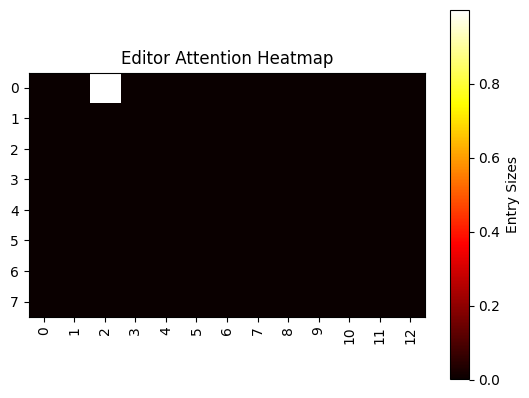

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


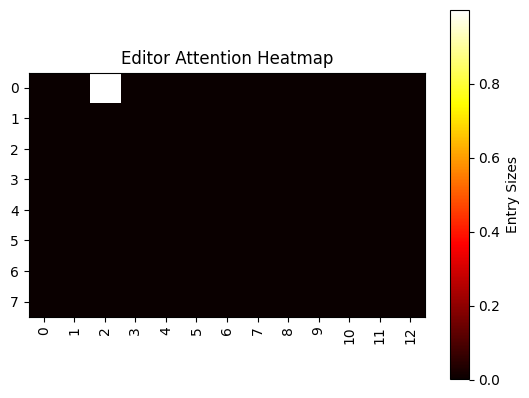

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


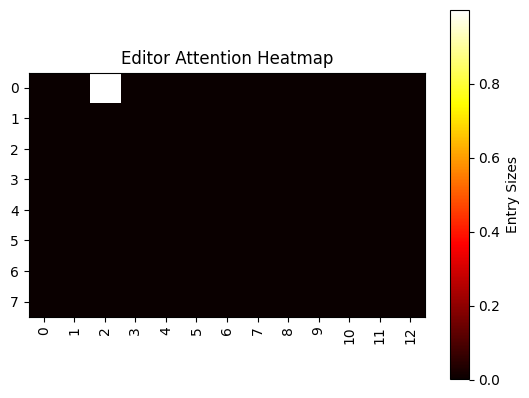

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


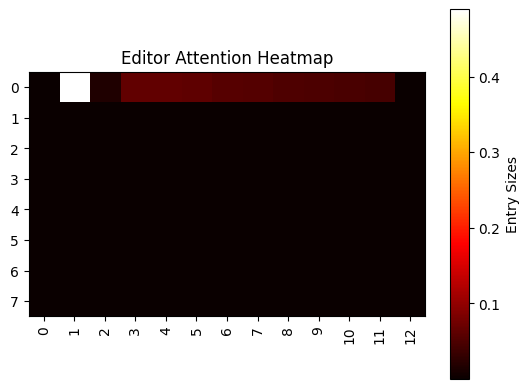

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


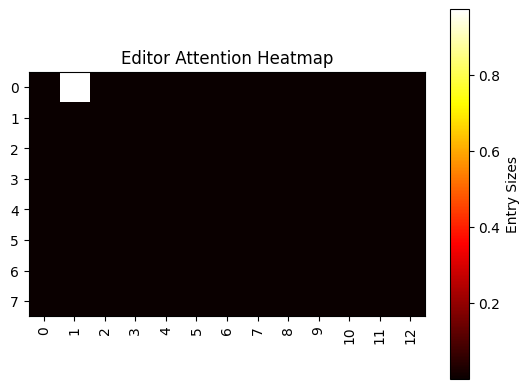

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


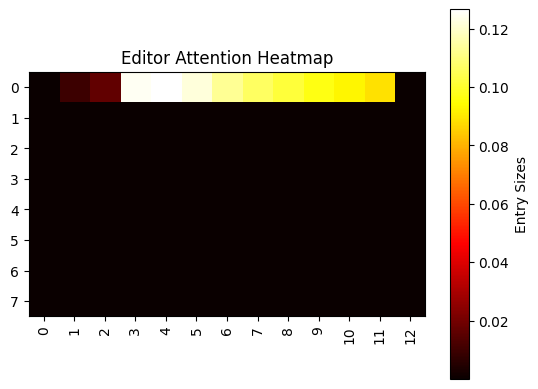

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


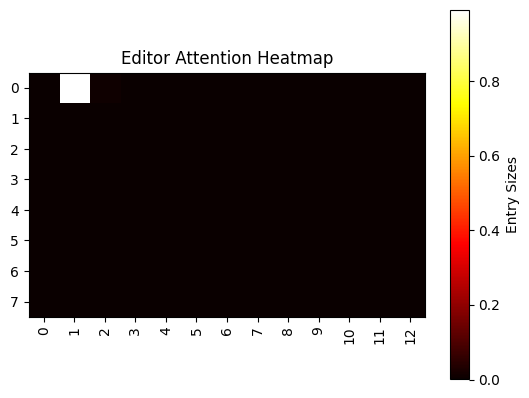

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


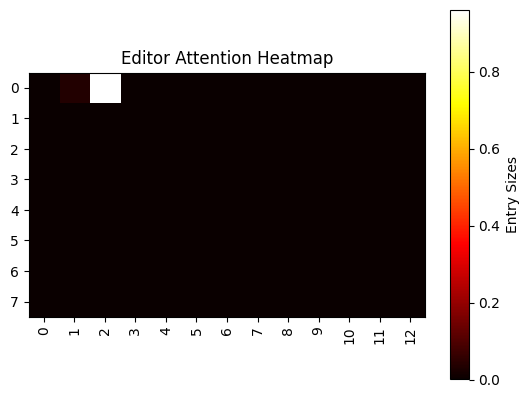

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


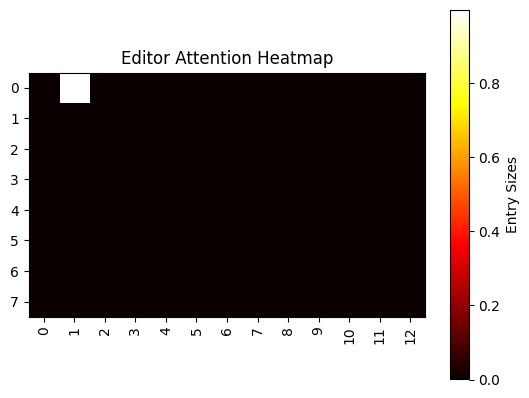

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


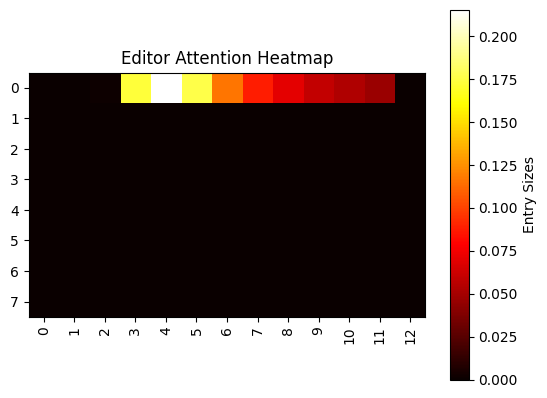

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


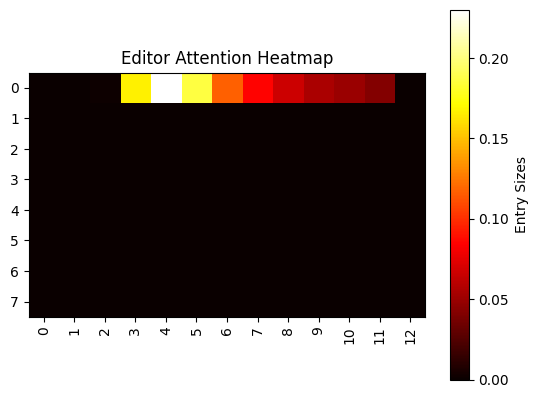

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


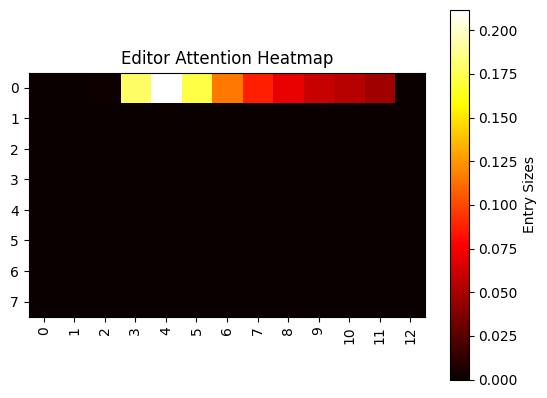

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


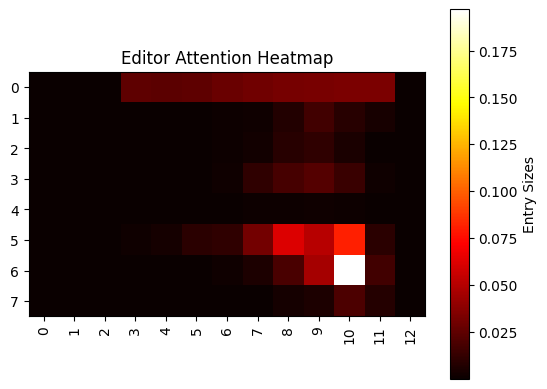

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


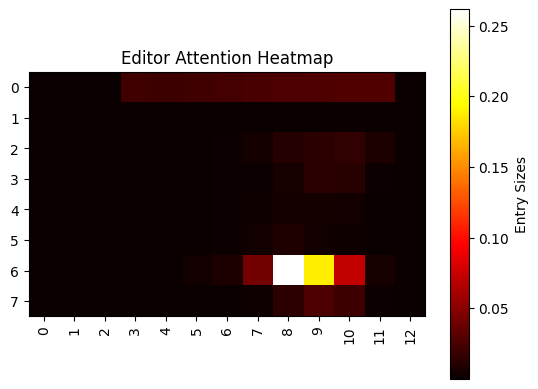

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


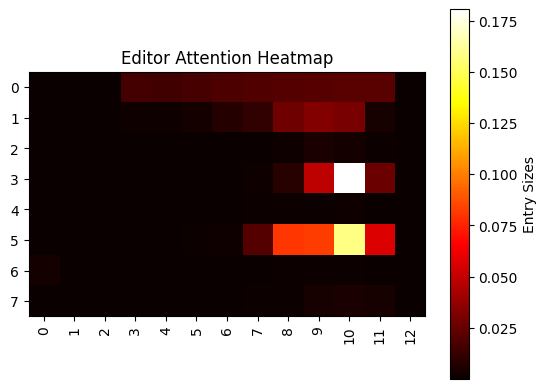

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


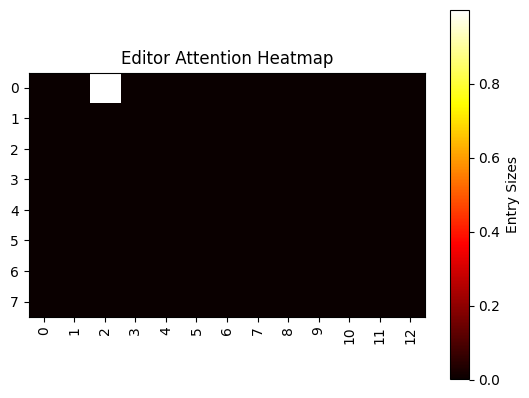

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


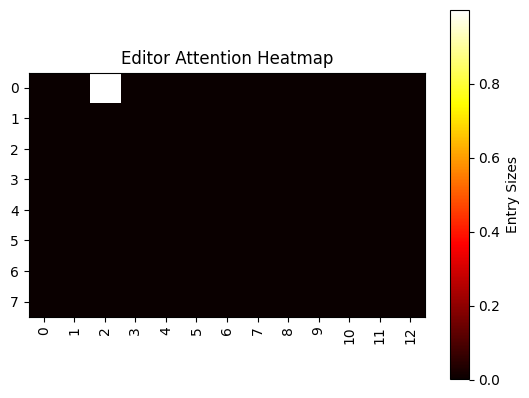

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


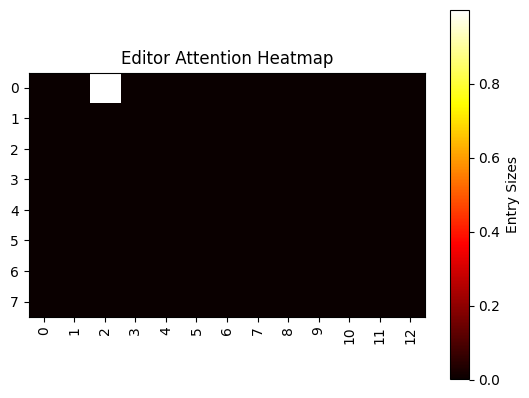

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


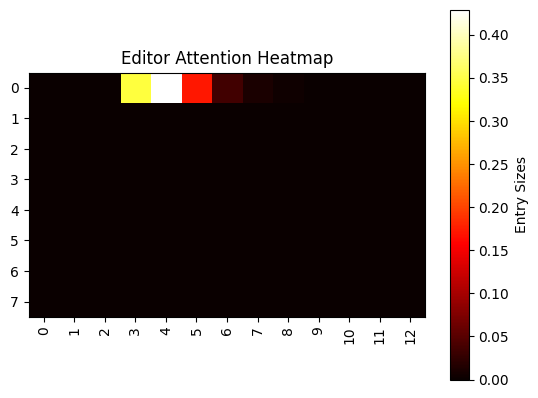

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


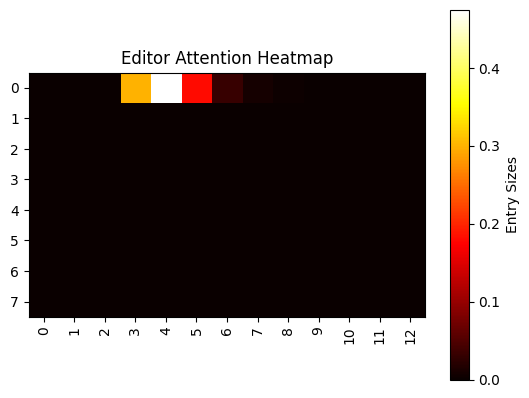

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


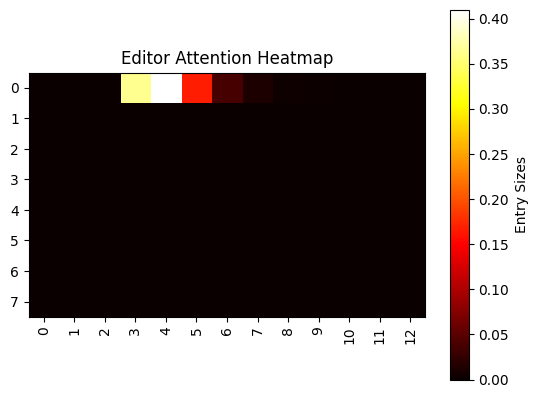

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


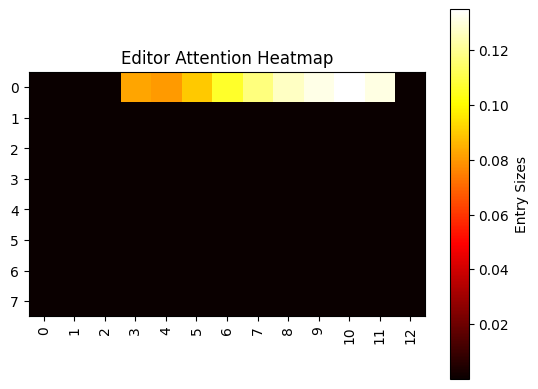

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


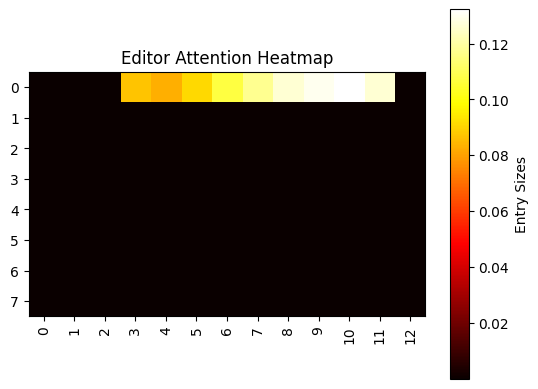

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


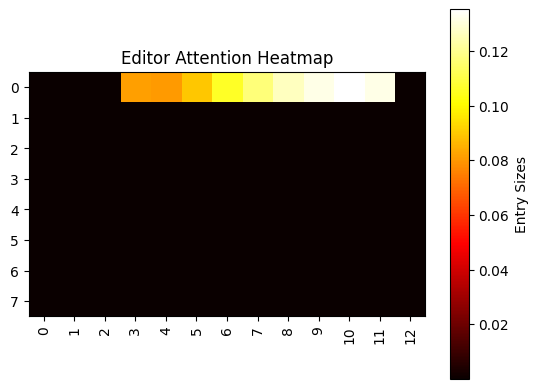

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


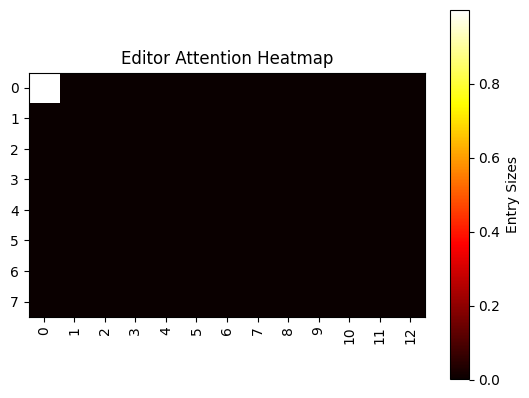

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


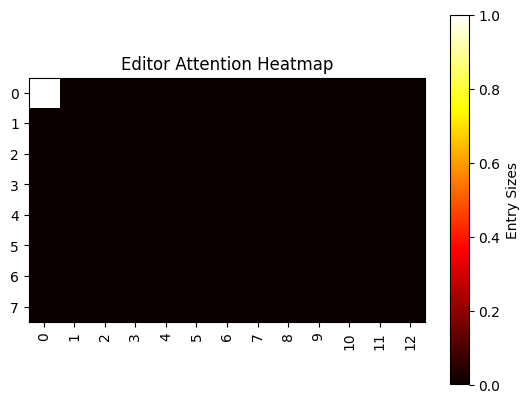

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


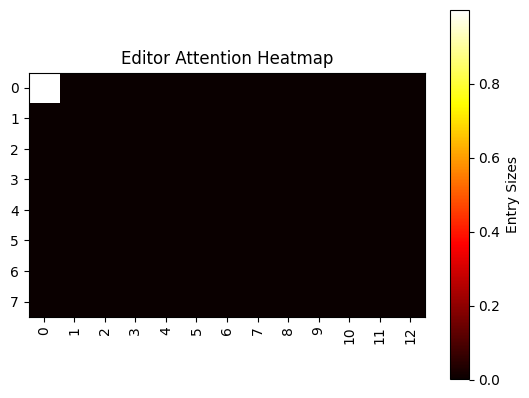

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


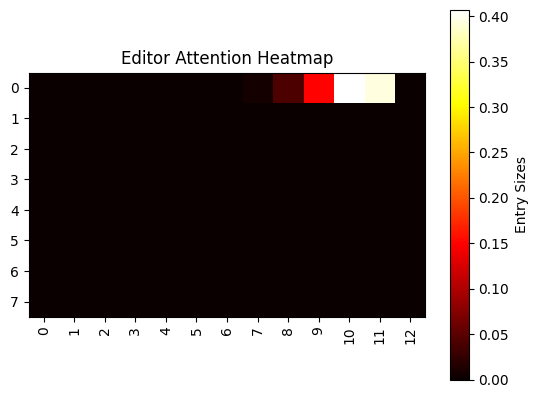

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


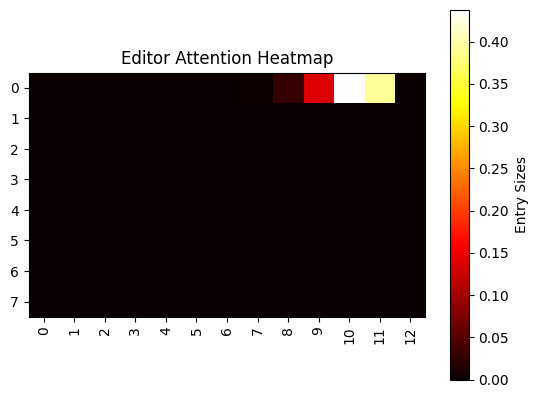

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


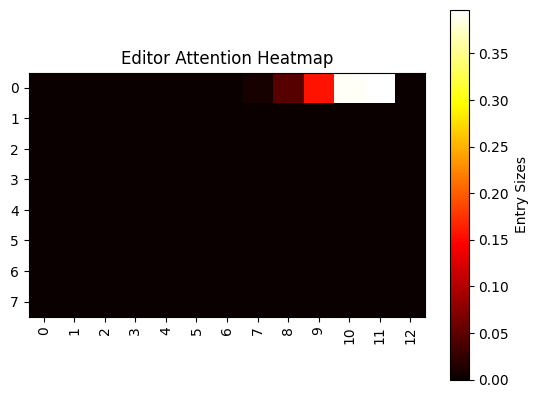

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


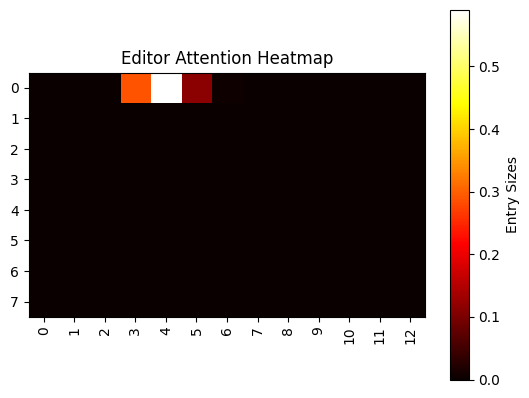

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


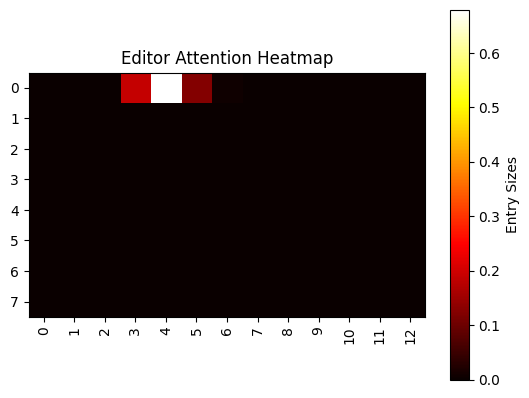

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


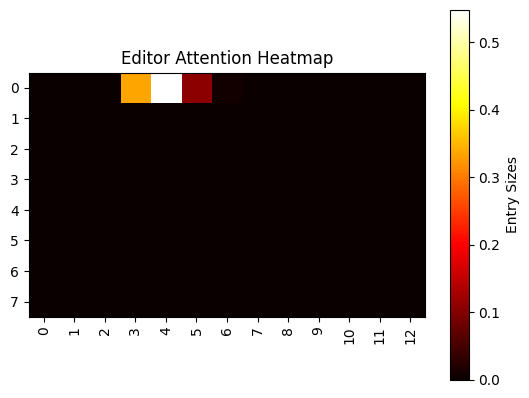

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


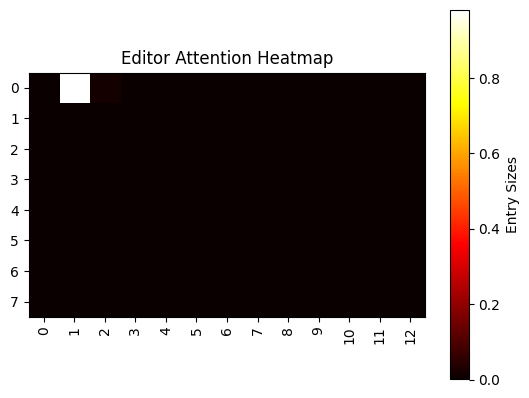

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


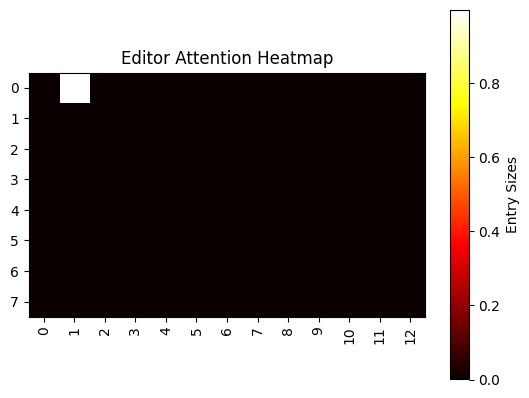

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


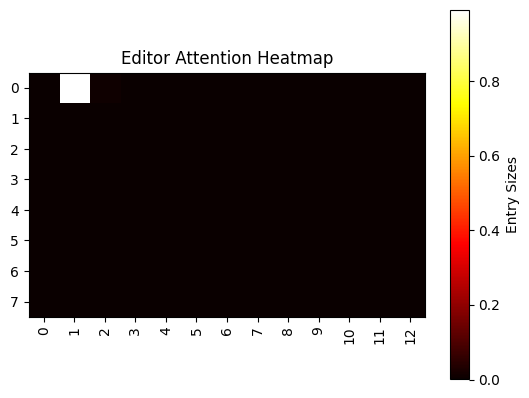

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


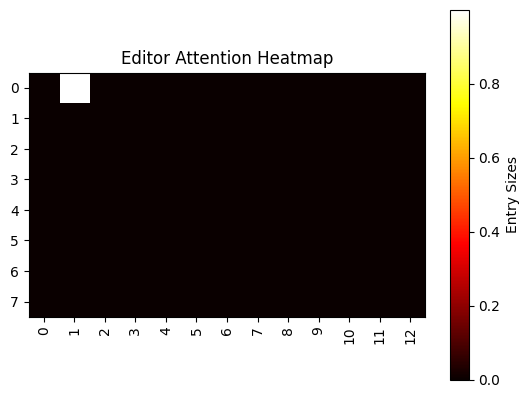

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


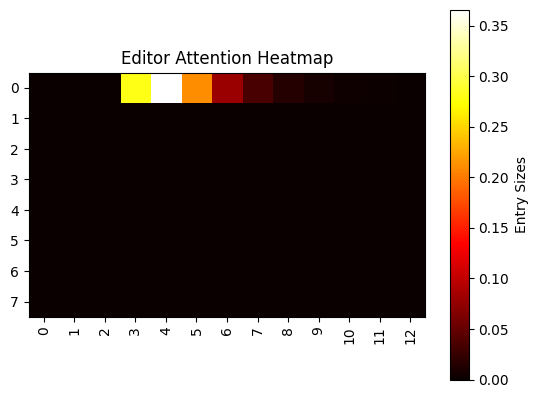

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


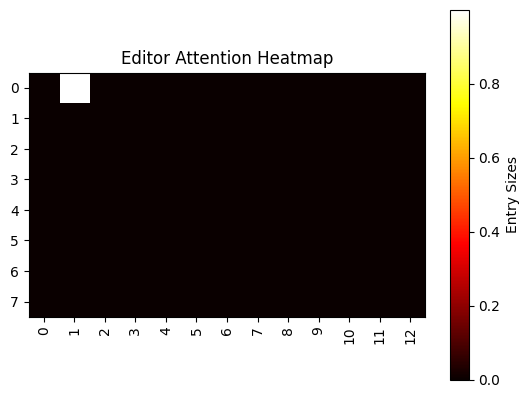

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


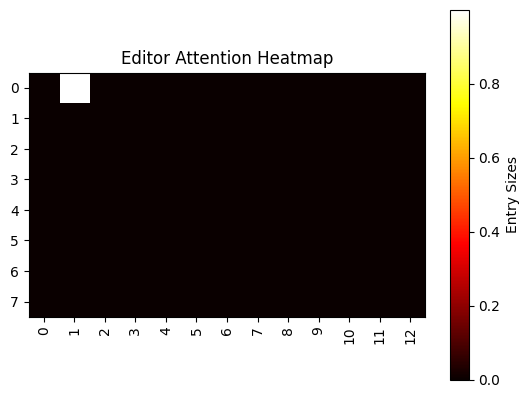

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


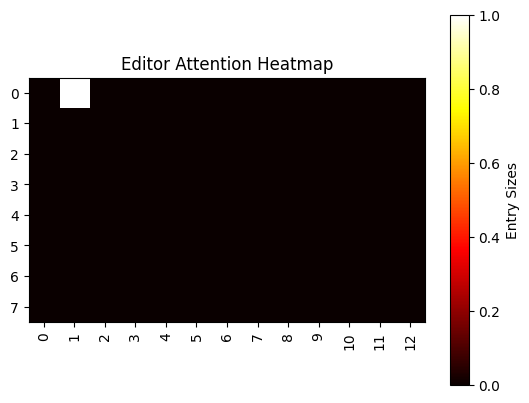

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


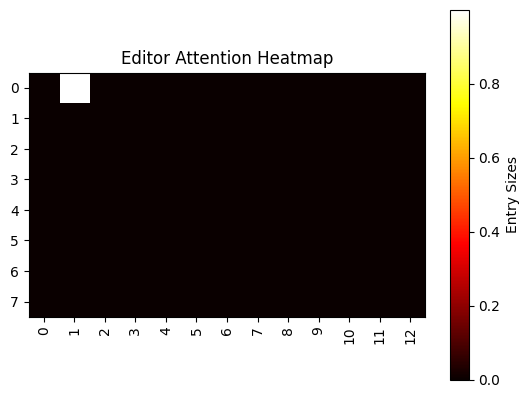

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


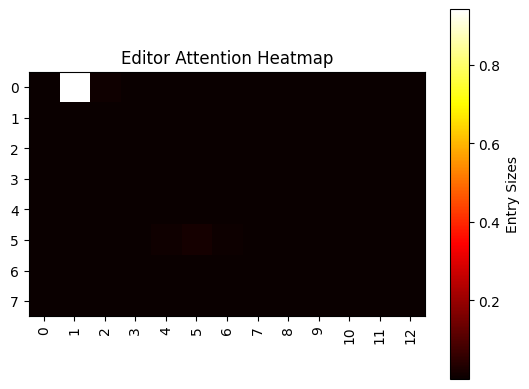

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


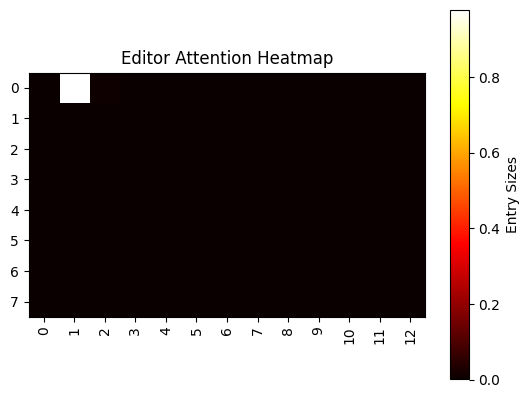

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


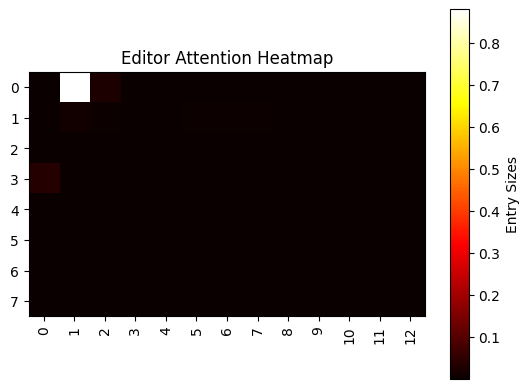

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


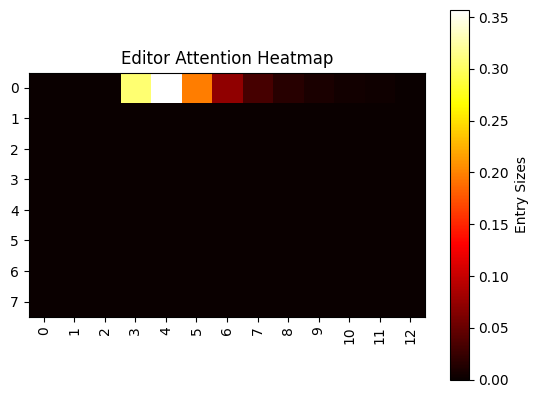

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


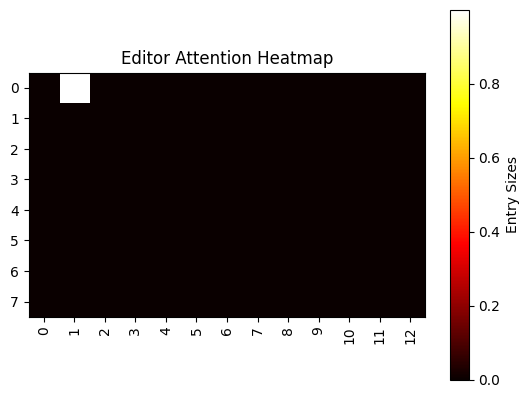

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


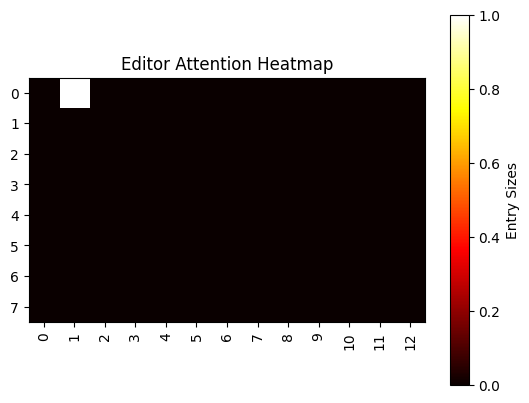

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


In [ ]:
#Heatmap for first attention head
import matplotlib.pyplot as plt
import numpy as np
stopping_index = 8
head_index = 1

for head_index in range(hypernetwork.editor_model.config.num_editing_heads):
    for batch_index in range(3):#range(5)

        # Reshape the tensor into an 8x13 matrix
        attention_matrix = result["editor_attention"][batch_index][head_index].reshape(8, 13).to("cpu")

        # is this any better??
        # attention_matrix = result['editor_attention'][batch_index].reshape(104).to("cpu").reshape(13,8).permute(1,0)

        # Detach and convert to numpy
        attention_matrix = attention_matrix.detach().numpy()

        # Create the heatmap
        fig, ax = plt.subplots()
        heatmap = ax.imshow(attention_matrix, cmap="hot")

        # Color the heatmap according to the entry sizes
        heatmap.set_clim(vmin=np.min(attention_matrix), vmax=np.max(attention_matrix))
        cbar = plt.colorbar(heatmap)
        cbar.set_label("Entry Sizes")

        # Add labels to the x and y axes
        ax.set_xticks(np.arange(13))
        ax.set_yticks(np.arange(8))
        ax.set_xticklabels(np.arange(13))
        ax.set_yticklabels(np.arange(8))

        # Rotate the x-axis labels
        plt.xticks(rotation=90)

        # Add a title
        plt.title("Editor Attention Heatmap")

        # Show the plot
        plt.show()

        intended_position = dataset['train']["edit_result_ids"][batch_index][0:8].index(3797)
        print(intended_position)
        print(tokenizer.batch_decode(dataset['train']["edit_result_ids"][batch_index][0:8]))

In [ ]:
# torch.norm(
#     result["edit_vectors"][batch_index][:stopping_index, :, :].to("cpu"), dim=[0, 2]
# )  # looks better now!

Notes: It seems, currently, like we are not giving sufficient incentive to intervene at the lowest possible layer

In [ ]:
result["edit_vectors"].shape

torch.Size([20, 18, 13, 768])

In [ ]:

edit_tensor = result["edit_vectors"][batch_index].reshape(8, 13, -1).to("cpu")
edit_tensor_norm = edit_tensor.norm(dim=2)
edit_tensor_norm.shape

torch.Size([8, 13])

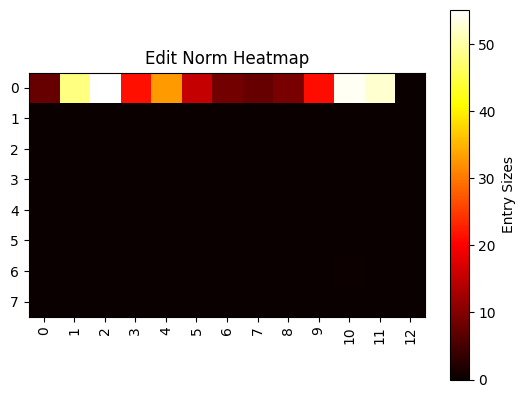

1
['The', ' cat', ',', ' with', ' its', ' fur', ' like', ' silk']


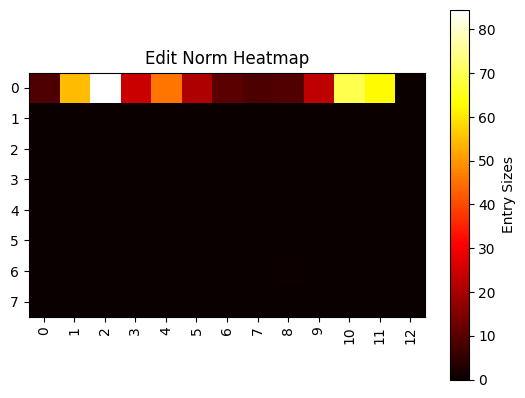

7
['In', ' the', ' alley', ',', ' a', ' shy', ' black', ' cat']


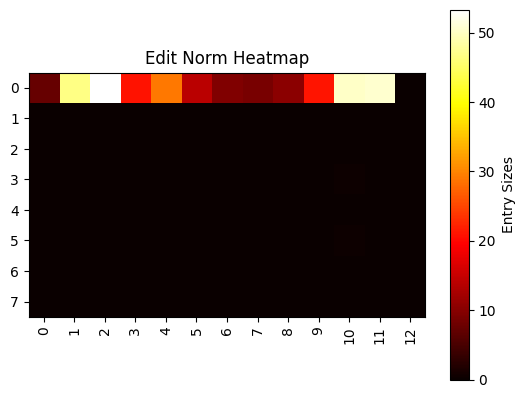

2
['A', ' fluffy', ' cat', ' pr', 'anced', ' grace', 'fully', ' through']


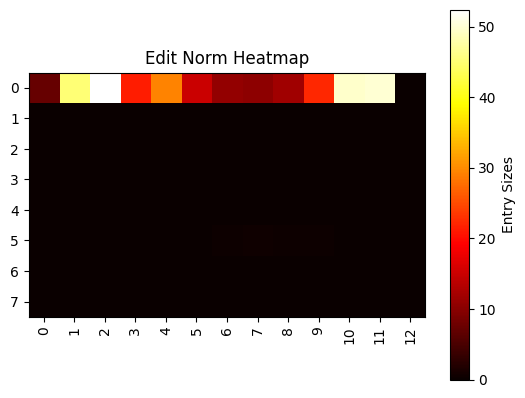

2
['A', ' playful', ' cat', ' p', 'ounced', ' on', ' the', ' yarn']


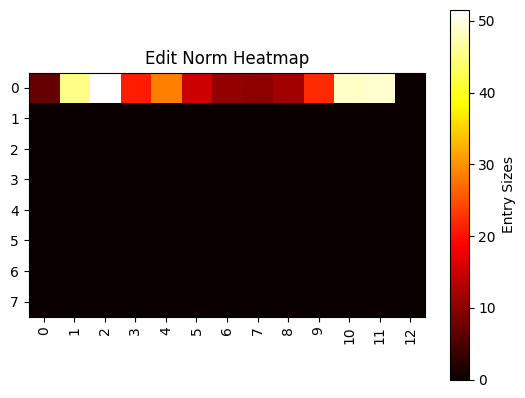

2
['A', ' playful', ' cat', ' chased', ' after', ' the', ' butterfly', '.']


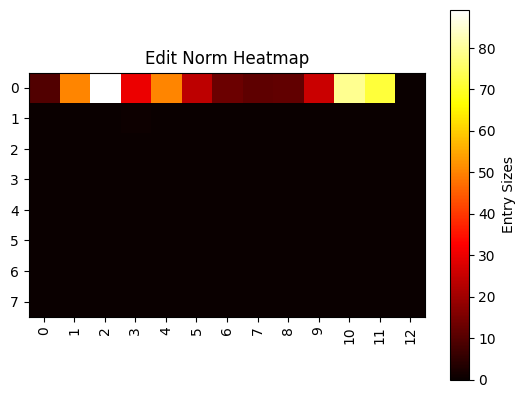

6
['With', ' graceful', ' steps', ',', ' the', ' elegant', ' cat', ' prow']


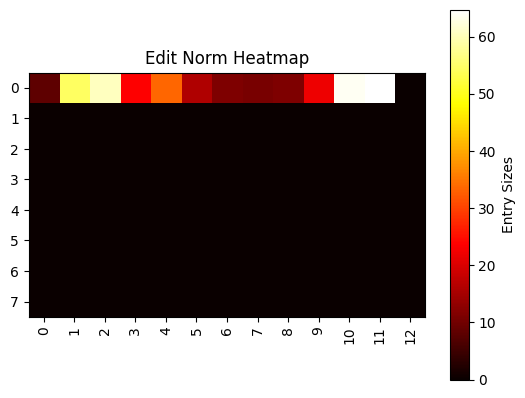

2
['A', ' curious', ' cat', ' crept', ' quietly', ' through', ' the', ' grass']


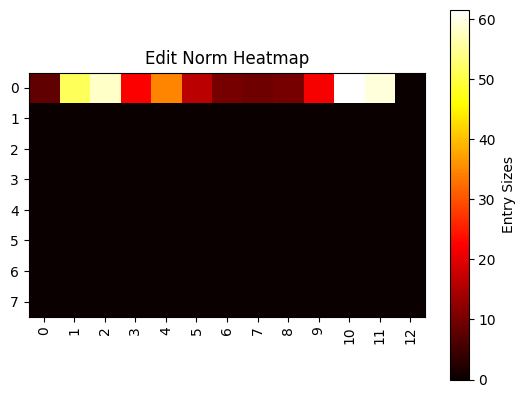

2
['The', ' curious', ' cat', ' chased', ' butterflies', ' through', ' the', ' me']


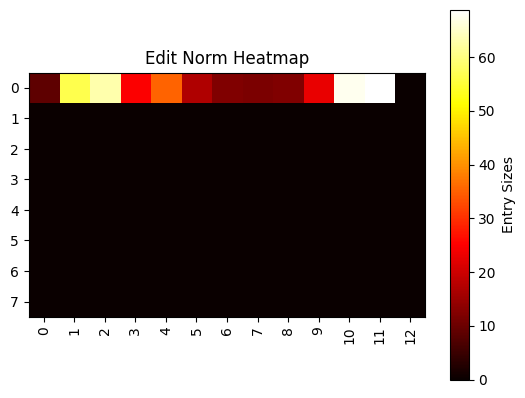

2
['A', ' mysterious', ' cat', ' silently', ' prow', 'led', ' through', ' the']


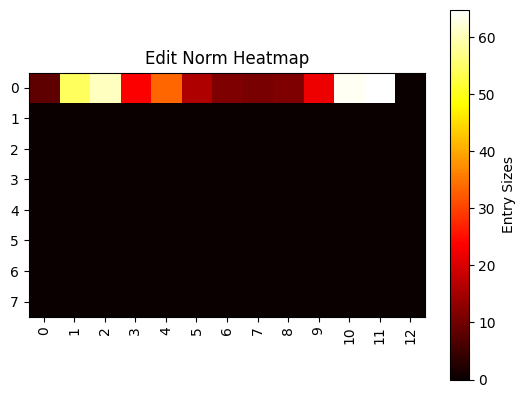

2
['A', ' curious', ' cat', ' crept', ' silently', ' through', ' the', ' bushes']


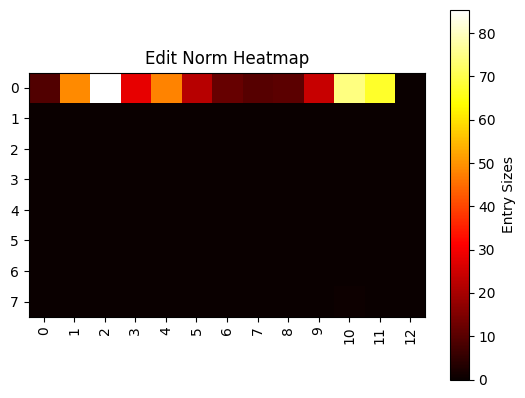

6
['With', ' a', ' graceful', ' leap', ',', ' the', ' cat', ' p']


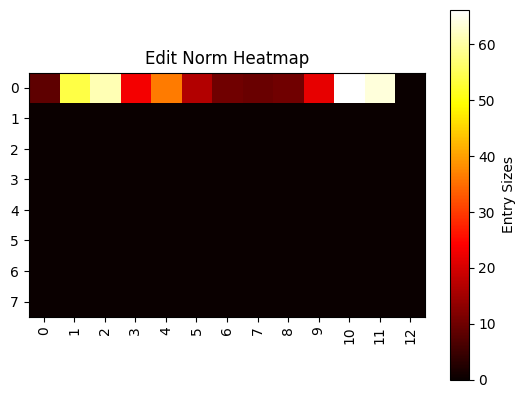

2
['The', ' curious', ' cat', ' pur', 'red', ' softly', ' in', ' the']


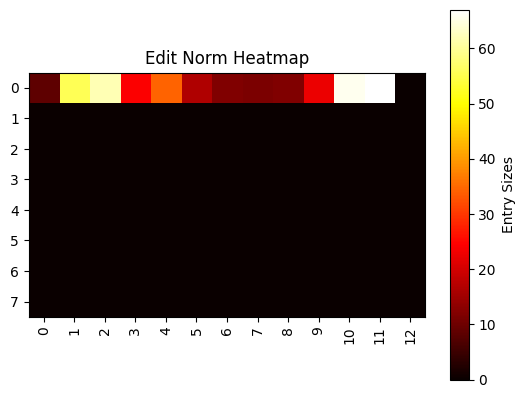

2
['A', ' curious', ' cat', ' proudly', ' walked', ' along', ' the', ' fence']


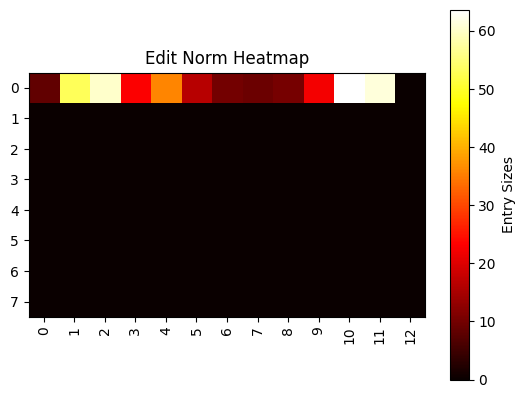

1
['The', ' cat', ' pur', 'red', ' softly', ' as', ' the', ' sun']


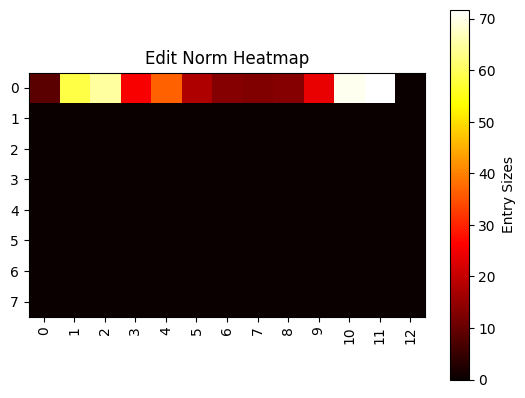

3
['A', ' sleek', ' black', ' cat', ' prow', 'led', ' through', ' the']


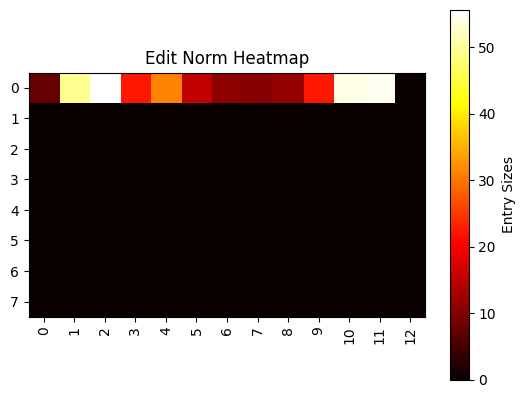

2
['A', ' playful', ' cat', ' prow', 'led', ' through', ' the', ' garden']


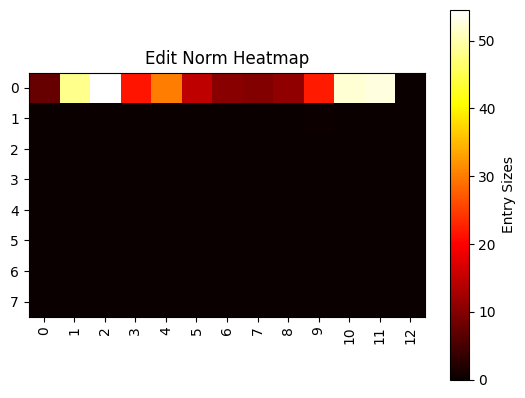

3
['A', ' whims', 'ical', ' cat', ' me', 'ows', ' under', ' the']


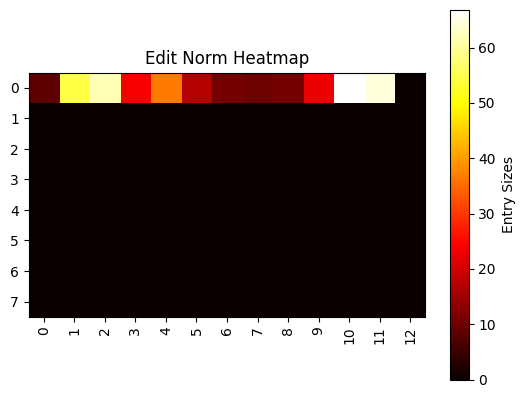

2
['The', ' graceful', ' cat', ' quietly', ' prow', 'led', ' through', ' the']


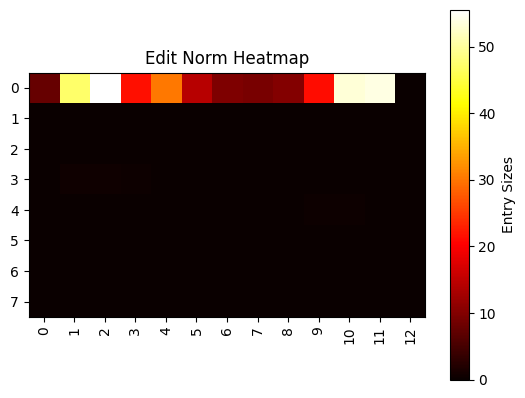

2
['A', ' fluffy', ' cat', ' lou', 'ng', 'ed', ' laz', 'ily']


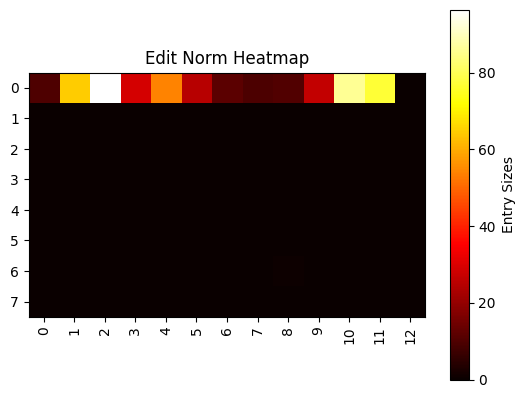

7
['In', ' the', ' moon', 'light', ',', ' a', ' black', ' cat']


In [ ]:
for batch_index in range(20):

    #The tensor norm comes in an 8x13 matrix
    edit_tensor = result["edit_vectors"][batch_index].to("cpu")
    edit_tensor_norm = edit_tensor.norm(dim=2)

    # is this any better??
    # attention_matrix = result['editor_attention'][batch_index].reshape(104).to("cpu").reshape(13,8).permute(1,0)

    # Detach and convert to numpy
    edit_tensor_norm = edit_tensor_norm.detach().numpy()[0:stopping_index, :]

    # Create the heatmap
    fig, ax = plt.subplots()
    heatmap = ax.imshow(edit_tensor_norm, cmap="hot")

    # Color the heatmap according to the entry sizes
    heatmap.set_clim(vmin=np.min(0), vmax=np.max(edit_tensor_norm))
    cbar = plt.colorbar(heatmap)
    cbar.set_label("Entry Sizes")

    # Add labels to the x and y axes
    ax.set_xticks(np.arange(13))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(np.arange(13))
    ax.set_yticklabels(np.arange(8))

    # Rotate the x-axis labels
    plt.xticks(rotation=90)

    # Add a title
    plt.title("Edit Norm Heatmap")

    # Show the plot
    plt.show()

    intended_position = dataset['train']["target_input_ids"][batch_index][0:8].index(3797)
    print(intended_position)
    print(tokenizer.batch_decode(dataset['train']["target_input_ids"][batch_index][0:8]))

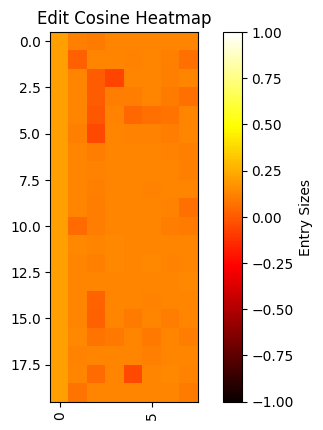

In [ ]:
#modifying the below chunk to work for layer 6

#Now, more graphs on the cosine direction with the correct edit


edit_tensor = result["edit_vectors"].to("cpu")

# is this any better??
# attention_matrix = result['editor_attention'][batch_index].reshape(104).to("cpu").reshape(13,8).permute(1,0)

# Detach and convert to numpy

edit_tensor_cosine= torch.nn.functional.cosine_similarity(edit_tensor[:,:8,edit_layer,:],edit_embedding.to("cpu")[None,None,:],dim=-1)
edit_cosine_matrix = edit_tensor_cosine.detach().numpy()

# Create the heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(edit_cosine_matrix, cmap="hot")

# Color the heatmap according to the entry sizes
heatmap.set_clim(vmin=-1, vmax=1)
cbar = plt.colorbar(heatmap)
cbar.set_label("Entry Sizes")

# Add labels to the x and y axes
# ax.set_xticks(np.arange(13))
# ax.set_yticks(np.arange(8))
# ax.set_xticklabels(np.arange(13))
# ax.set_yticklabels(np.arange(8))

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Add a title
plt.title("Edit Cosine Heatmap")

# Show the plot
plt.show()



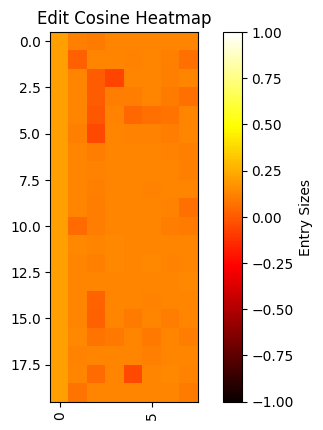

7
['In', ' the', ' moon', 'light', ',', ' a', ' black', ' cat']


In [ ]:
#Now, more graphs on the cosine direction with the correct edit


edit_tensor = result["edit_vectors"].to("cpu")

# is this any better??
# attention_matrix = result['editor_attention'][batch_index].reshape(104).to("cpu").reshape(13,8).permute(1,0)

# Detach and convert to numpy

edit_tensor_cosine= torch.nn.functional.cosine_similarity(edit_tensor[:,:8,0,:],edit_embedding.to("cpu")[None,None,:],dim=-1)
edit_cosine_matrix = edit_tensor_cosine.detach().numpy()

# Create the heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(edit_cosine_matrix, cmap="hot")

# Color the heatmap according to the entry sizes
heatmap.set_clim(vmin=-1, vmax=1)
cbar = plt.colorbar(heatmap)
cbar.set_label("Entry Sizes")

# Add labels to the x and y axes
# ax.set_xticks(np.arange(13))
# ax.set_yticks(np.arange(8))
# ax.set_xticklabels(np.arange(13))
# ax.set_yticklabels(np.arange(8))

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Add a title
plt.title("Edit Cosine Heatmap")

# Show the plot
plt.show()

intended_position = dataset['train']["edit_result_ids"][batch_index][0:8].index(3797)
print(intended_position)
print(tokenizer.batch_decode(dataset['train']["edit_result_ids"][batch_index][0:8]))

In [ ]:
edited_states = torch.stack(result['edited_hidden_states'],dim = 2)
edited_states.shape

torch.Size([20, 18, 13, 768])

In [ ]:
for i in range(8):
    print(edited_states[0][i][0].norm())

tensor(10.8428, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(6.0581, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.4851, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.0293, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.1574, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.4300, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(4.9236, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(5.4054, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
# # Some basic checks of embedding norms 

# # Access the embedding layer
# embeddings = model.get_input_embeddings()

# # Get the weight matrix of the embeddings
# embedding_weights = embeddings.weight

# # Calculate the L2 norm for each embedding vector
# norms = torch.norm(embedding_weights, p=2, dim=1)

# # Iterate over each token in the tokenizer to display its norm
# token_norms = {}
# for token, index in tokenizer.get_vocab().items():
#     token_norms[token] = norms[index].item()

# # Example output for a few tokens
# # for token, norm in list(token_norms.items())[:100]:  # Displaying the first 10 for brevity
# #     print(f"Token: {token}, Norm: {norm}")

# print(embedding_weights.shape)

# print(token_norms)

# #plt.hist(list(token_norms.values()), bins=100)

# # Access the positional embedding layer
# positional_embeddings = model.transformer.wpe.weight  # For GPT-2, positional embeddings are accessed via `wpe` attribute

# print(positional_embeddings.shape)

# # Calculate the L2 norm for each positional embedding vector
# positional_norms = torch.norm(positional_embeddings, p=2, dim=1)

# print(torch.min(positional_norms), torch.max(positional_norms))

# # Print the norms of the first few positional embeddings
# for position, norm in enumerate(positional_norms[:10]):  # Displaying the first 10 for brevity
#     plt.hist(list(positional_norms.to('cpu').detach().numpy()), bins=100)


In [ ]:
print(
    torch.norm(result['target_hidden_states'][0][6][0]),
    torch.norm(result['target_hidden_states'][0][0][0]),
    edited_states[0][6][0].norm(),
    edited_states[0][2][0].norm()
)


tensor(4.9236, device='cuda:0') tensor(10.1320, device='cuda:0') tensor(4.9236, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(5.4851, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
# We checked below that passing a custom edit-vector into the embedding, would do the job!
# Note, though, by the way, that this completely avoids calling the editor model
# So the editor model is not confirmed to be bugless
# neither is the KL! So, we should check that the KL is working as intended / going down, etc.
with torch.no_grad():
    outputs = model(tokenizer.encode(' cat', return_tensors = 'pt'), output_hidden_states = True)
    embedding_of_cat = outputs.hidden_states[0][0][0]
    outputs = model(tokenizer.encode(' dog', return_tensors = 'pt'), output_hidden_states = True)
    embedding_of_dog = outputs.hidden_states[0][0][0]
    edit_embedding = embedding_of_dog - embedding_of_cat

torch.norm(edit_embedding)

tensor(3.0707, device='cuda:0')

In [ ]:
embedding_of_dog.norm(), embedding_of_cat.norm(), (embedding_of_cat - embedding_of_dog).norm()

(tensor(10.2354, device='cuda:0'),
 tensor(10.2971, device='cuda:0'),
 tensor(3.0707, device='cuda:0'))

In [ ]:
edit_tensor.shape, edit_tensor[:stopping_index,0,:].shape
torch.norm(edit_tensor[:stopping_index,0,:],dim=1)

tensor([[5.6314, 5.7225, 3.4713,  ..., 5.1689, 4.6435, 4.6939],
        [7.0765, 6.6888, 4.3226,  ..., 6.1390, 5.5605, 5.9459],
        [5.3128, 5.4486, 2.9866,  ..., 4.5737, 4.3870, 4.2891],
        ...,
        [7.8270, 6.8479, 5.0374,  ..., 6.5869, 6.2647, 6.5773],
        [6.6738, 6.4988, 4.1062,  ..., 5.3537, 5.0358, 5.1082],
        [6.2576, 6.2365, 4.0922,  ..., 5.3974, 5.0343, 5.1012]],
       grad_fn=<LinalgVectorNormBackward0>)

In [ ]:

#getting batch edit vectors implemented/checked for a single batch element
edit_input_ids = torch.tensor(dataset['train']['editor_input_ids'][0:1])
data_example = torch.tensor(dataset['train']['edit_result_ids'][0:1])
cat_example = data_example
dog_example = cat_example.clone()
dog_example[:,:stop_editing_index][dog_example[:,:stop_editing_index] == 3797] = 3290
batched_embedding_diff = torch.zeros(1,8,13,768)
cat_index = torch.where(cat_example == 3797)
cat_index = cat_index[1][0] #Confused why there are two indices here, but I think the second one is the one we want
#batched_embedding_diff[0,cat_index,0,:] = edit_embedding
batched_embedding_diff[0,cat_index,0,:] = edit_embedding
test_output = hypernetwork(editor_input_ids = editor_input_ids,
            target_input_ids = cat_example,
            batch_edit_vectors = batched_embedding_diff,
            stop_editing_index=stop_editing_index,
            output_target_hidden_states=True,
            output_edited_hidden_states=True)
#test_output['edited_hidden_states'][0][0,7][0:10] - model(cat_example,output_hidden_states = True).hidden_states[0][0][7][0:10]
## it's exactly equal to: # edit_embedding[0:10] #Good! So, the edit vector inputs functionality is working


# edit_input_ids = torch.tensor(dataset['editor_input_ids'][0:2])
# data_example = torch.tensor(dataset['edit_result_ids'][0:2])
# prob_predictions = torch.nn.functional.softmax(
#     test_output["logits"][
#         :, :-stop_editing_index, :
#     ].reshape(-1, 50257),
# )
# soft_labels = f_data_to_soft_labels(
#                 torch.tensor(dataset['edit_result_ids'][0:2]),
#                 stop_editing_index,
#             )

In [ ]:
# tempdata = torch.tensor(dataset['edit_result_ids'][0:1])
# tempdata[:, :stop_editing_index][tempdata[:, :stop_editing_index] == 3797] = 3290
# with torch.no_grad():
#     logits = model(tempdata).logits
#     predictions = torch.nn.functional.softmax(logits, dim=2)
#     temp_output = predictions[:, stop_editing_index:, :].reshape(-1, 50257)
# error = temp_output - nn.functional.softmax(test_output['logits'],dim=2)[0,stop_editing_index:,:]
# torch.max(error)

In [ ]:
# torch.save(hypernetwork.state_dict(), "/root/aiplay-1/hypernetworks/hypernetwork.pth")